# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

In [5]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
sys.path.append('../')

import warnings
from utility_2 import run_cv_one_motor, read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg, show_reg_result, show_clf_result

sys.path.append('../../supporting_scripts/WP_1')
from utility import read_all_csvs_one_test

In [6]:
base_dictionary = '../../dataset/training_data/'

# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()



import matplotlib.pyplot as plt
import pandas as pd
import os

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')



#### Use the correlation matrix to select the 5 most correlated features to temperature of motor 6

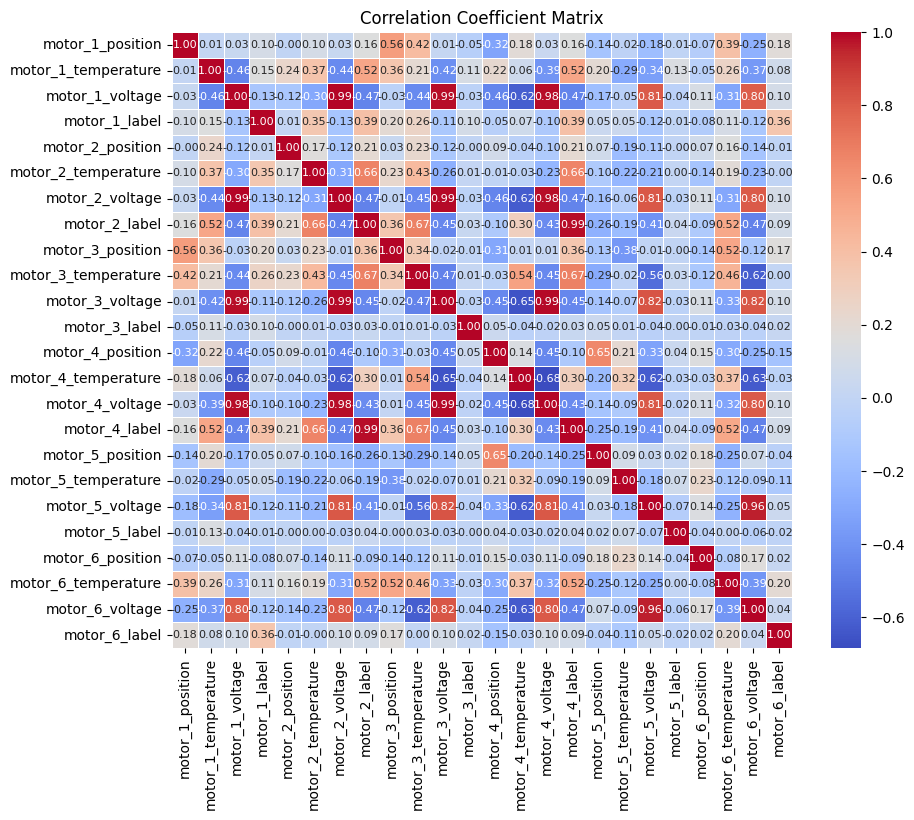

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

col_to_plot = [col for col in df_data_smoothing.columns if ('time' not in col and 'test' not in col)]

df_matrix = df_data_smoothing.loc[:, col_to_plot]

correlation_matrix = df_matrix.corr()

correlation_matrix.columns = [col[5:] for col in correlation_matrix.columns]
correlation_matrix.index = [index[5:] for index in correlation_matrix.index]

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})

plt.title('Correlation Coefficient Matrix')
plt.show()

According to the correlation matrix the 5 most correlated features to motor 6 temperature are : 
- motor 1 position
- motor 1 temperature
- motor 3 position
- motor 3 temperature
- motor 4 temperature

In [7]:
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

from utility_2 import run_cv_one_motor
feature_list = ['data_motor_1_position','data_motor_1_temperature',
                    'data_motor_3_position', 'data_motor_3_temperature',
                    'data_motor_4_temperature']


threshold = 1
window_size = 1
sample_step = 1

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings("ignore")

models = list()
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),
    ('regressor', LinearRegression())  
]
models.append(steps)
steps = [
    ('standardizer', StandardScaler()),
    ('regressor', Ridge())  
]
models.append(steps)
steps = [
    ('standardizer', StandardScaler()),
    ('regressor', Lasso())  
]
models.append(steps)
steps = [
    ('standardizer', StandardScaler()),
    ('regressor', ElasticNet())  
]
models.append(steps)

for i in range(len(models)):
    step = models[i]
    print(step)
    # Create the pipeline
    mdl_linear_regression = Pipeline(step)
    df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_linear_regression, 
                feature_list=feature_list, n_fold=5, single_run_result=False,
                threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')
    

[('standardizer', StandardScaler()), ('regressor', LinearRegression())]
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   6.374642  3.373646              0.590054
1  11.101056  4.516360              0.870177
2   7.575855  4.264967              0.888416
3   9.206185  4.288158              0.958791
4  15.510556  6.421784              0.937309


Mean performance metric and standard error:
Max error: 9.9537 +- 3.5783
RMSE: 4.5730 +- 1.1220
Exceed boundary rate: 0.8489 +- 0.1491


[('standardizer', StandardScaler()), ('regressor', Ridge())]
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   6.374374  3.373397              0.590054
1  11.098917  4.515946              0.870177
2   7.575832  4.264986              0.888416
3   9.205912  4.288090              0.958791
4  15.510478  6.421728              0.937309


Mean performance metric and standard error:
Max error: 9.9531 +- 3.5782
RMSE: 4.5728 +- 1.1221
Exceed boundary rate: 0.8489 +- 0.1491


[('standardiz

In [15]:

models = list()
models_name = ["Decision Tree", 'Random Forest', "Gradient Boosting", "KNeighborsRegressor", "BaggingRegressor","Suppor Vector Regressor"]

steps = [
    ('standardizer', StandardScaler()),
    ('regressor', DecisionTreeRegressor())  
]
models.append(steps)
steps = [
    ('standardizer', StandardScaler()),
    ('regressor', RandomForestRegressor())  
]
models.append(steps)
steps = [
    ('standardizer', StandardScaler()),
    ('regressor', GradientBoostingRegressor())  
]
models.append(steps)
steps = [
    ('standardizer', StandardScaler()),
    ('regressor', KNeighborsRegressor())  
]
models.append(steps)
steps = [
    ('standardizer', StandardScaler()),
    ('regressor', BaggingRegressor())  
]
models.append(steps)


for i in range(len(models)):
    step = models[i]
    print(step)
    # Create the pipeline
    mdl_linear_regression = Pipeline(step)
    df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_linear_regression, 
                feature_list=feature_list, n_fold=5, single_run_result=False,
                threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

[('standardizer', StandardScaler()), ('regressor', DecisionTreeRegressor())]
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   8.472872  3.205288              0.728720
1  11.000000  4.112845              0.687307
2  12.957143  4.275885              0.955423
3  17.000000  7.373875              0.703297
4  16.000000  7.001186              0.838175


Mean performance metric and standard error:
Max error: 13.0860 +- 3.5164
RMSE: 5.1938 +- 1.8698
Exceed boundary rate: 0.7826 +- 0.1132


[('standardizer', StandardScaler()), ('regressor', RandomForestRegressor())]
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   8.381153  2.919323              0.960607
1   8.721833  3.534914              0.746678
2  10.133424  3.835739              0.956559
3  16.602732  7.203934              0.530220
4  16.000000  7.273747              0.865189


Mean performance metric and standard error:
Max error: 11.9678 +- 4.0158
RMSE: 4.9535 +- 2.1123
Exceed boundary rate: 0.8119 +-

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

steps = [
    ('standardizer', StandardScaler()),
    ('regressor', ElasticNet())  
]


feature_list = ['data_motor_1_position', 'data_motor_1_temperature',
                'data_motor_3_position', 'data_motor_3_temperature',
                'data_motor_4_temperature', 
                'data_motor_6_position','data_motor_6_temperature']


# Create the pipeline
mdl_linear_regression = Pipeline(steps)
df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_linear_regression, 
            feature_list=feature_list, n_fold=5, single_run_result=False,
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   5.469215  3.225394              0.708791
1   9.278249  3.663309              0.832819
2   6.669499  4.524010              0.907723
3   5.571564  2.985443              0.947802
4  15.232877  6.185519              0.936544


Mean performance metric and standard error:
Max error: 8.4443 +- 4.0937
RMSE: 4.1167 +- 1.2967
Exceed boundary rate: 0.8667 +- 0.0990




**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Linear  |   9.9537 +- 3.5783  |   4.5730 +- 1.1220  |  0.8489 +- 0.1491| 
| Ridge |   9.9531 +- 3.5782  |  4.5728 +- 1.1221  |  0.8489 +- 0.1491 | 
| Lasso |   9.0450 +- 4.1539 |   4.3476 +- 1.4546   |  0.8286 +- 0.0983 | 
| Elastic Net |   8.4443 +- 4.0937  |   4.1167 +- 1.2967   |  0.8667 +- 0.0990 | 
| Decision Tree |   13.0860 +- 3.5164  |   5.1938 +- 1.8698   |   0.7826 +- 0.1132 | 
| Random Forest |   11.9678 +- 4.0158  |   4.9535 +- 2.1123   |  0.8119 +- 0.1799 | 
| Gradient Boosting |  9.3144 +- 3.9303   |  3.9886 +- 1.6644    |  0.8396 +- 0.0567 | 
| K_neighbours |   12.1360 +- 4.0076 |  4.8042 +- 1.9631  |0.7482 +- 0.1635  | 
| Bagging | 11.5173 +- 4.5063 | 5.0289 +- 2.0733  | 0.7902 +- 0.1287 | 



## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

feature_list = ['data_motor_1_position','data_motor_1_temperature',
                    'data_motor_3_position', 'data_motor_3_temperature',
                    'data_motor_4_temperature']

models = [Pipeline(steps = [
                        ('standardizer', StandardScaler()),
                        ('regressor', ElasticNet())]),
          Pipeline(steps = [
                        ('standardizer', StandardScaler()),
                        ('regressor', GradientBoostingRegressor())])
        ]
window_range = [3, 10, 20, 50]
sample_range = [1, 2]
prediction_lead_time_range = [1, 5, 10]

threshold = 1


for i in range(len(models)):
    for window in window_range:
        print(f"Modèle : {models[i]}, Window : {window}, Sample : {1}, Prediction : {1}")
        
        run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=models[i], 
    feature_list=feature_list, n_fold=5, single_run_result=False,
    threshold=threshold, window_size=window, sample_step=1, mdl_type='reg')

Modèle : Pipeline(steps=[('standardizer', StandardScaler()),
                ('regressor', ElasticNet())]), Window : 3, Sample : 1, Prediction : 1
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   1.915739  1.293470              0.586875
1   3.922326  1.482914              0.440820
2   2.715249  1.555308              0.716116
3   1.079739  0.646216              0.272222
4   5.300257  2.154775              0.719612


Mean performance metric and standard error:
Max error: 2.9867 +- 1.6647
RMSE: 1.4265 +- 0.5424
Exceed boundary rate: 0.5471 +- 0.1915


Modèle : Pipeline(steps=[('standardizer', StandardScaler()),
                ('regressor', ElasticNet())]), Window : 10, Sample : 1, Prediction : 1
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   1.314190  0.752911              0.176938
1   2.477581  0.741283              0.240763
2   2.108643  0.879954              0.212252
3   0.724634  0.259383              0.000000
4   3.179018  1.146024            

In [11]:
from sklearn.linear_model import LinearRegression
mdl = Pipeline(steps = [
                        ('standardizer', StandardScaler()),
                        ('regressor', LinearRegression())])

for window in [5,30, 100]:
    for sample_step in [1, 2]:
        print("Linear, Window : ", window, " sample", sample)
        run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl, 
            feature_list=feature_list, n_fold=5, single_run_result=False, 
            threshold=threshold, window_size=window, sample_step=sample_step, mdl_type='reg')

Linear, Window :  5  sample 1
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   0.189291  0.022821                   0.0
1   0.199045  0.014260                   0.0
2   0.180752  0.020888                   0.0
3   0.114520  0.012272                   0.0
4   0.300925  0.025378                   0.0


Mean performance metric and standard error:
Max error: 0.1969 +- 0.0670
RMSE: 0.0191 +- 0.0056
Exceed boundary rate: 0.0000 +- 0.0000


Linear, Window :  5  sample 1
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   0.371307  0.037867                   0.0
1   0.397515  0.026746                   0.0
2   0.390189  0.042847                   0.0
3   0.202180  0.026437                   0.0
4   0.602337  0.053133                   0.0


Mean performance metric and standard error:
Max error: 0.3927 +- 0.1421
RMSE: 0.0374 +- 0.0113
Exceed boundary rate: 0.0000 +- 0.0000


Linear, Window :  30  sample 1
Model for motor 6:
   Max error      RMSE  Exceed bound

In [13]:
from sklearn.linear_model import LinearRegression
mdl = Pipeline(steps = [
                        ('standardizer', StandardScaler()),
                        ('regressor', LinearRegression())])

for pred in [2, 5, 10, 30]:
    print("Linear, pred", pred)
    run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl, 
            feature_list=feature_list, n_fold=5, single_run_result=False, prediction_lead_time = pred,
            threshold=threshold, window_size=100, sample_step=1, mdl_type='reg')

Linear, pred 2
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   0.271212  0.031820                   0.0
1   0.384072  0.022088                   0.0
2   0.260011  0.036083                   0.0
3   0.190207  0.016822                   0.0
4   0.604534  0.044669                   0.0


Mean performance metric and standard error:
Max error: 0.3420 +- 0.1624
RMSE: 0.0303 +- 0.0111
Exceed boundary rate: 0.0000 +- 0.0000


Linear, pred 5
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   0.577559  0.071393              0.000000
1   0.940675  0.062434              0.000000
2   1.033249  0.117511              0.000991
3   0.519701  0.054838              0.000000
4   1.519179  0.134205              0.001134


Mean performance metric and standard error:
Max error: 0.9181 +- 0.4030
RMSE: 0.0881 +- 0.0355
Exceed boundary rate: 0.0004 +- 0.0006


Linear, pred 10
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   1.145606  0.154643              

In [8]:
mdl = Pipeline(steps = [
                        ('standardizer', StandardScaler()),
                        ('regressor', LinearRegression())])

for window in [20, 50, 100]:
    print("LInear, Window : ", window)
    run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl, prediction_lead_time=0,
        feature_list=feature_list, n_fold=5, single_run_result=False, 
        threshold=1, window_size=window, sample_step=1, mdl_type='reg')

LInear, Window :  20
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   0.199739  0.020189                   0.0
1   0.197888  0.012724                   0.0
2   0.149665  0.018756                   0.0
3   0.105790  0.011276                   0.0
4   0.306758  0.022762                   0.0


Mean performance metric and standard error:
Max error: 0.1920 +- 0.0750
RMSE: 0.0171 +- 0.0049
Exceed boundary rate: 0.0000 +- 0.0000


LInear, Window :  50
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   0.158606  0.018656                   0.0
1   0.193344  0.011773                   0.0
2   0.134080  0.017482                   0.0
3   0.099168  0.011323                   0.0
4   0.302456  0.021170                   0.0


Mean performance metric and standard error:
Max error: 0.1775 +- 0.0779
RMSE: 0.0161 +- 0.0043
Exceed boundary rate: 0.0000 +- 0.0000


LInear, Window :  100
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   0.152692  0.01

**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| GradientBoosting (window = 50, sample = 1, pred = 1) |   1.5921 +- 1.8370  |   0.3648 +- 0.5217   | 0.0442 +- 0.0811 | 
| ElasticNet (window = 20, sample = 1, pred = 1)|   2.3333 +- 1.1978 |   0.6944 +- 0.2808   | 0.1426 +- 0.1415 |  
| Linear  (window_size = 10, sample_step = 1, pred = 1) |   0.1965 +- 0.0666  |   0.0191 +- 0.0056   |  0.0000 +- 0.0000 | 
| Linear  (window_size = 100, sample_step = 1, pred = 5) |   0.9181 +- 0.4030  |   0.0881 +- 0.0355 | 0.0004 +- 0.0006 |
| Linear  (window_size = 100, sample_step = 1, pred = 1) |   0.1743 +- 0.0800  |  0.0152 +- 0.0055  |  0.0000 +- 0.0000 | 
| Linear  (window_size = 100, sample_step = 2, pred = 1) |   0.3415 +- 0.1647 | 0.0309 +- 0.0114 |  0.0000 +- 0.0000 | 
| Lasso  (window_size = 100, sample_step = 1, pred = 1) |  2.4447 +- 1.3929 | 1.0866 +- 0.4740 | 0.4483 +- 0.2686 | 


According to the different tests we made, it seems that the best result are with a Linear Regressor and a window_size of 100, sample step and prediction lead time of 1.  
Below, we can see the prediction thanks to those parameters. 

Model for motor 6:

 New run:

training performance, max error is: 0.29455117592767976
training performance, mean root square error is: 0.012908695837055586
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.15269247475226067
testing performance, mean root square error is: 0.01809723978872592
testing performance, residual error > 1: 0.0%


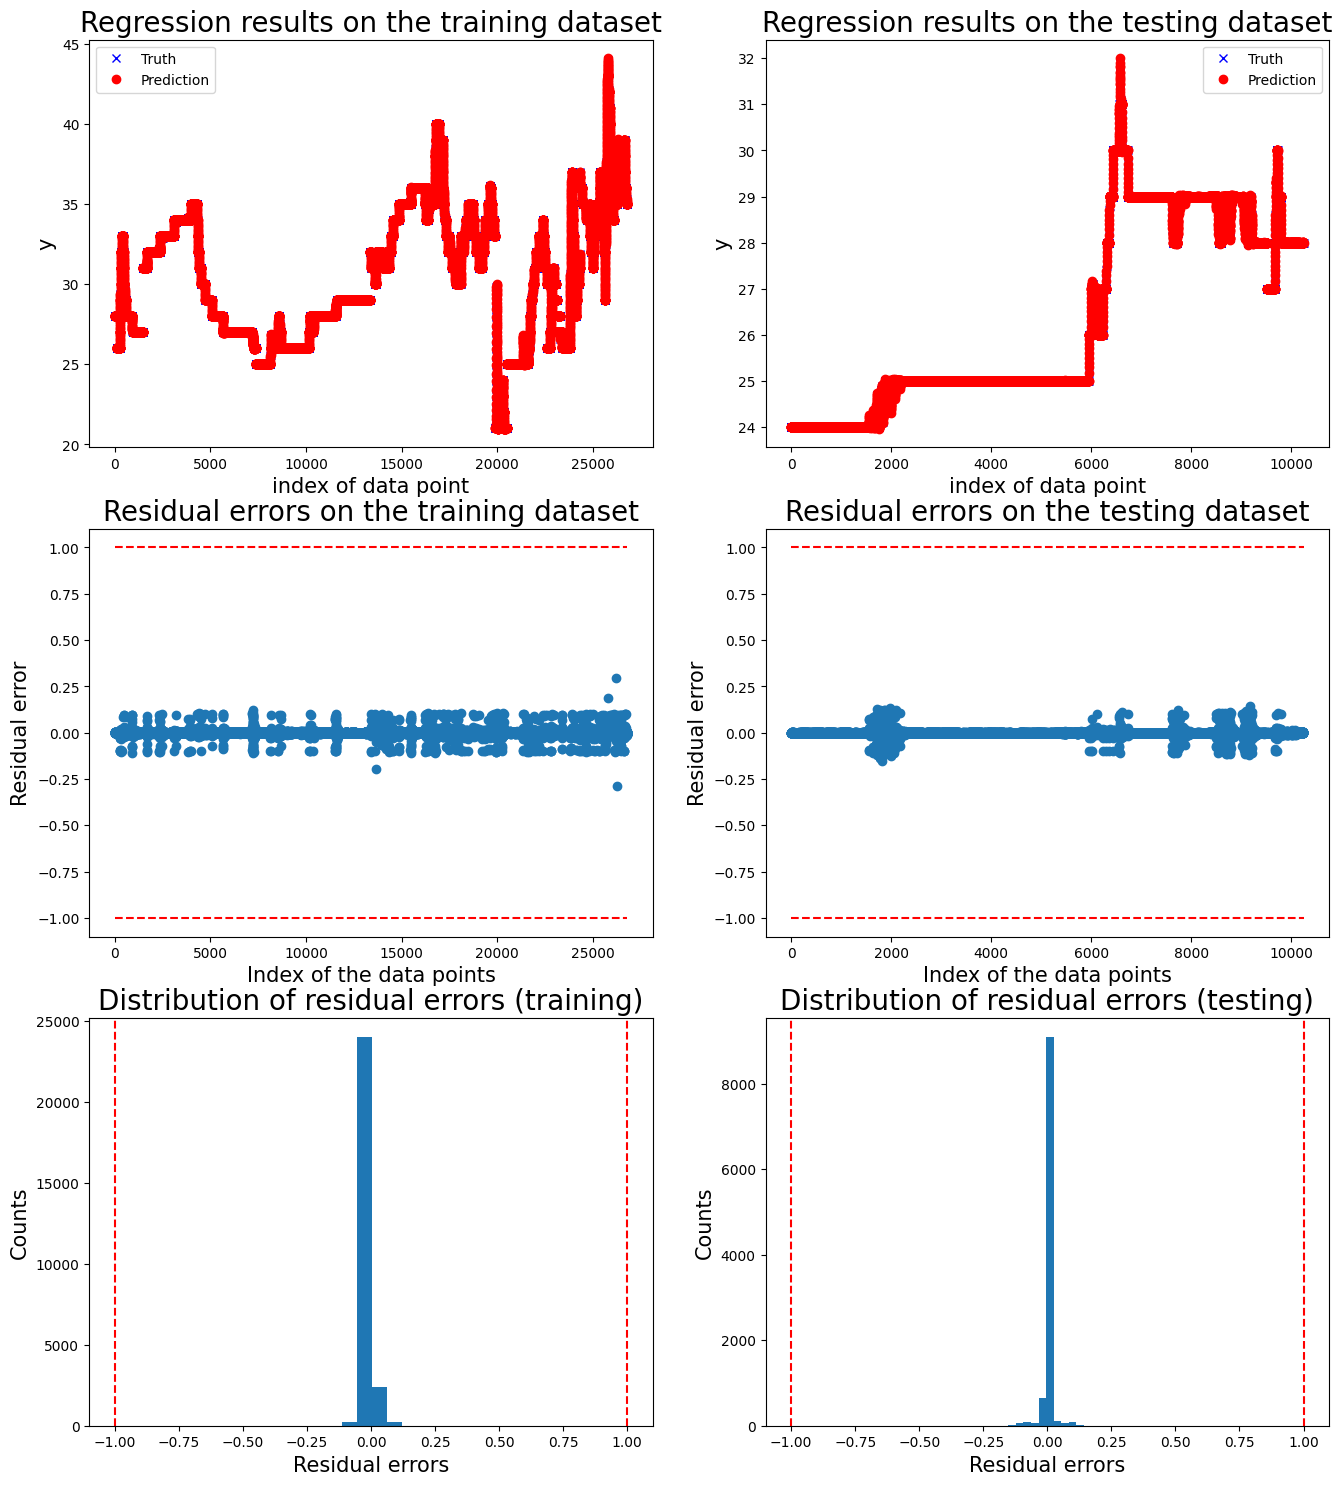


 New run:

training performance, max error is: 0.29313999819004266
training performance, mean root square error is: 0.017056704406094463
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.19280955946554101
testing performance, mean root square error is: 0.01172990195330396
testing performance, residual error > 1: 0.0%


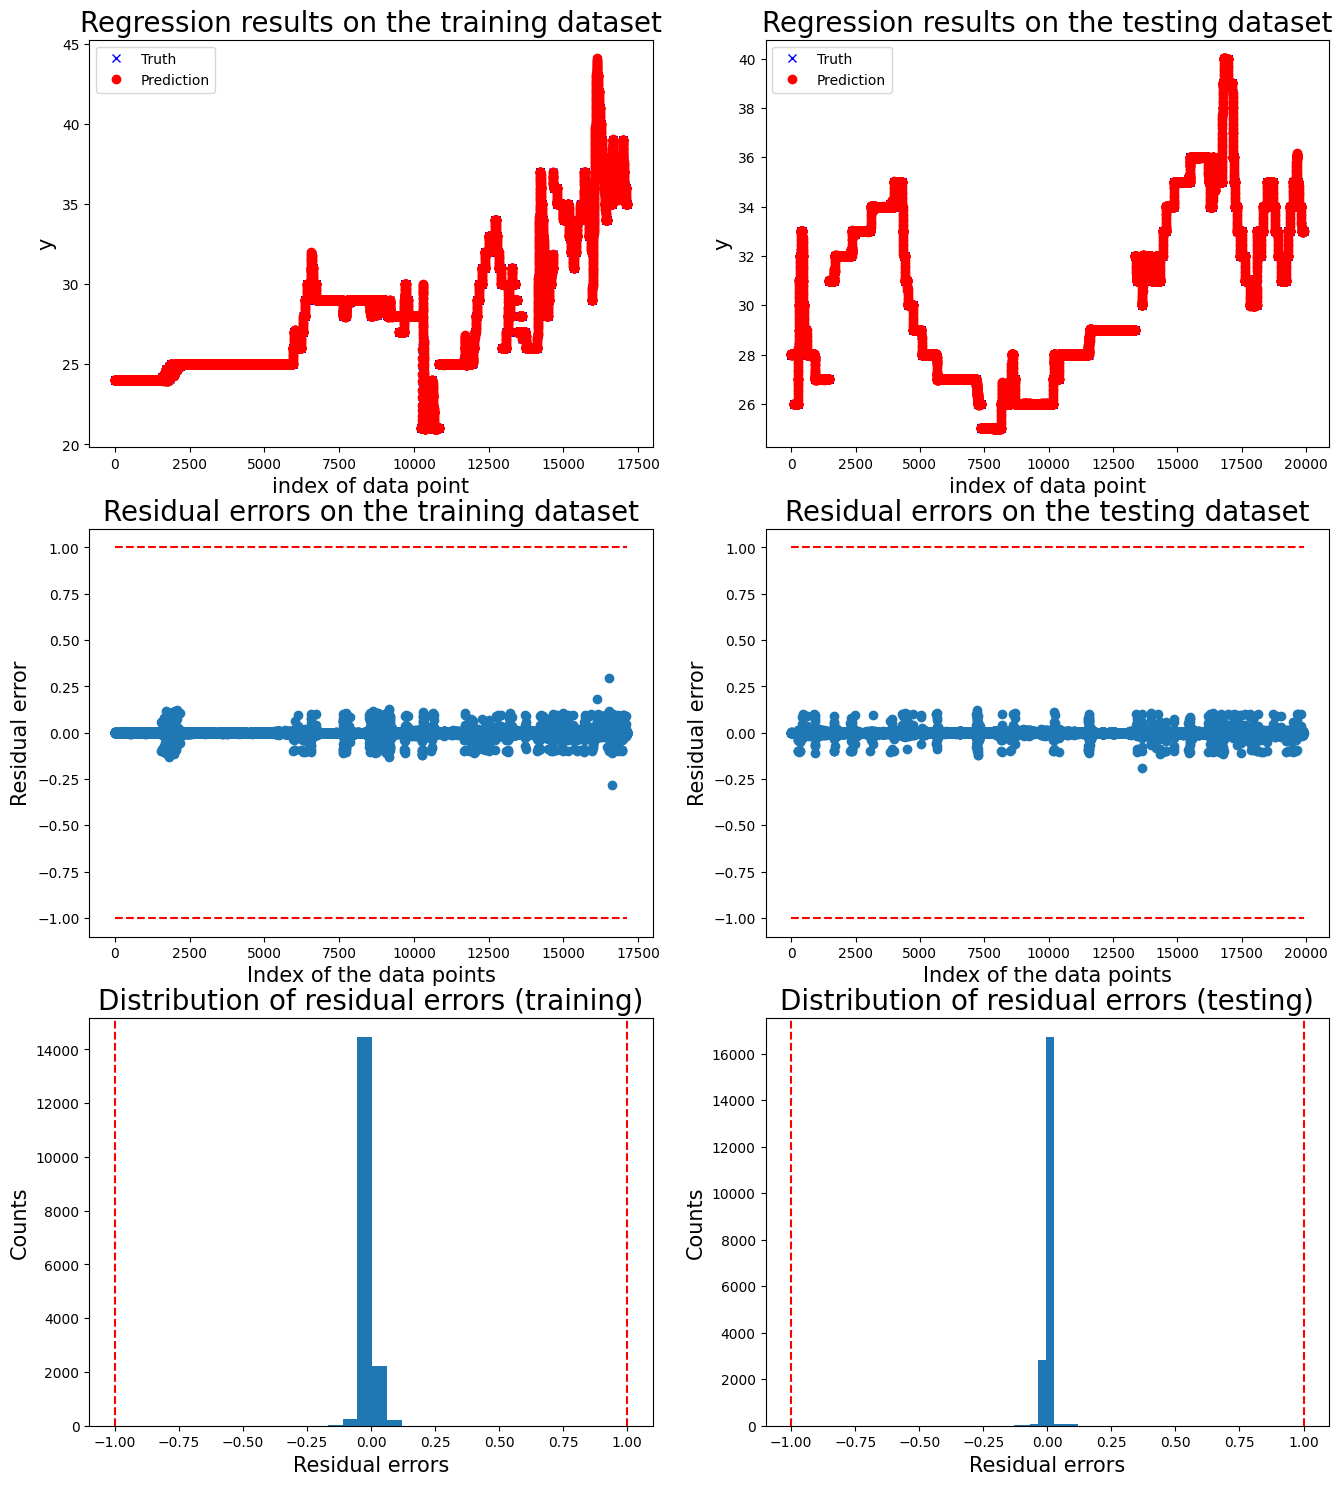


 New run:

training performance, max error is: 0.2935585720747085
training performance, mean root square error is: 0.013978906076723334
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.12866433006455935
testing performance, mean root square error is: 0.017471822124150195
testing performance, residual error > 1: 0.0%


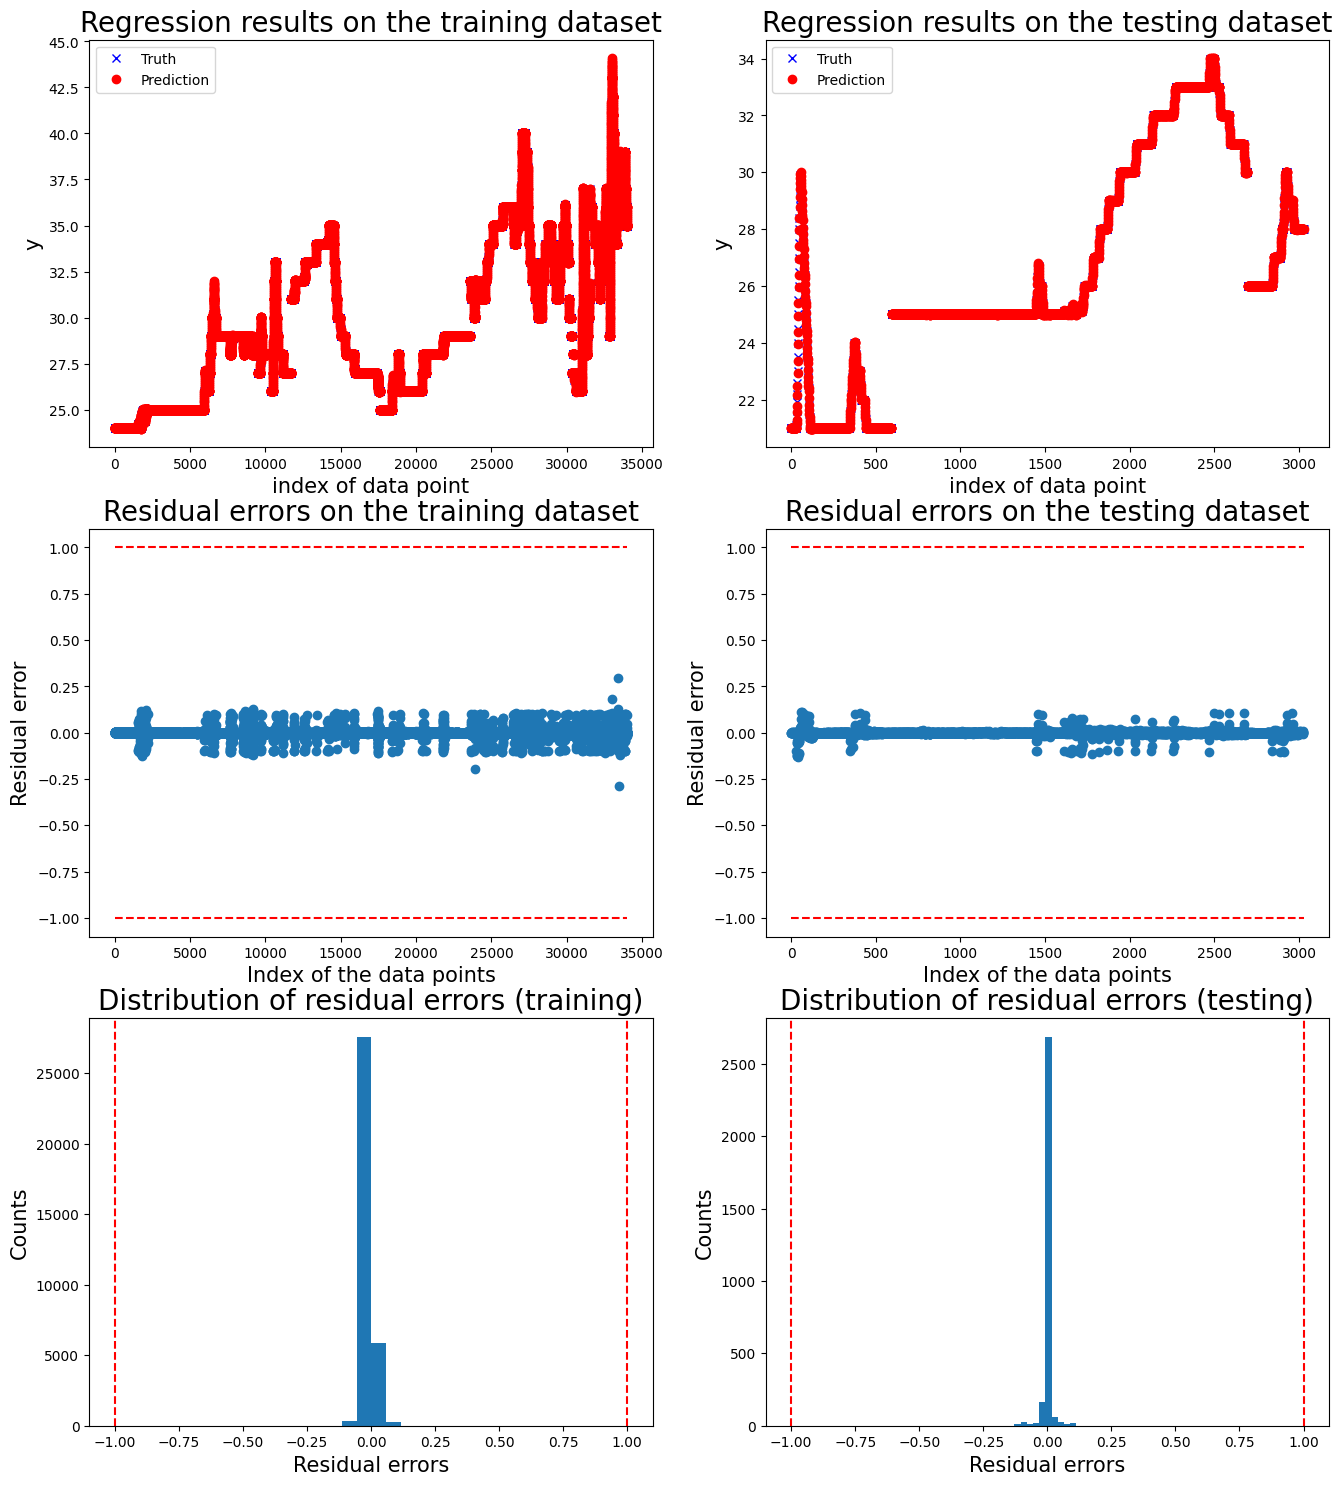


 New run:

training performance, max error is: 0.2965290456133616
training performance, mean root square error is: 0.014281752219036936
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.09487547924781126
testing performance, mean root square error is: 0.007488238213014178
testing performance, residual error > 1: 0.0%


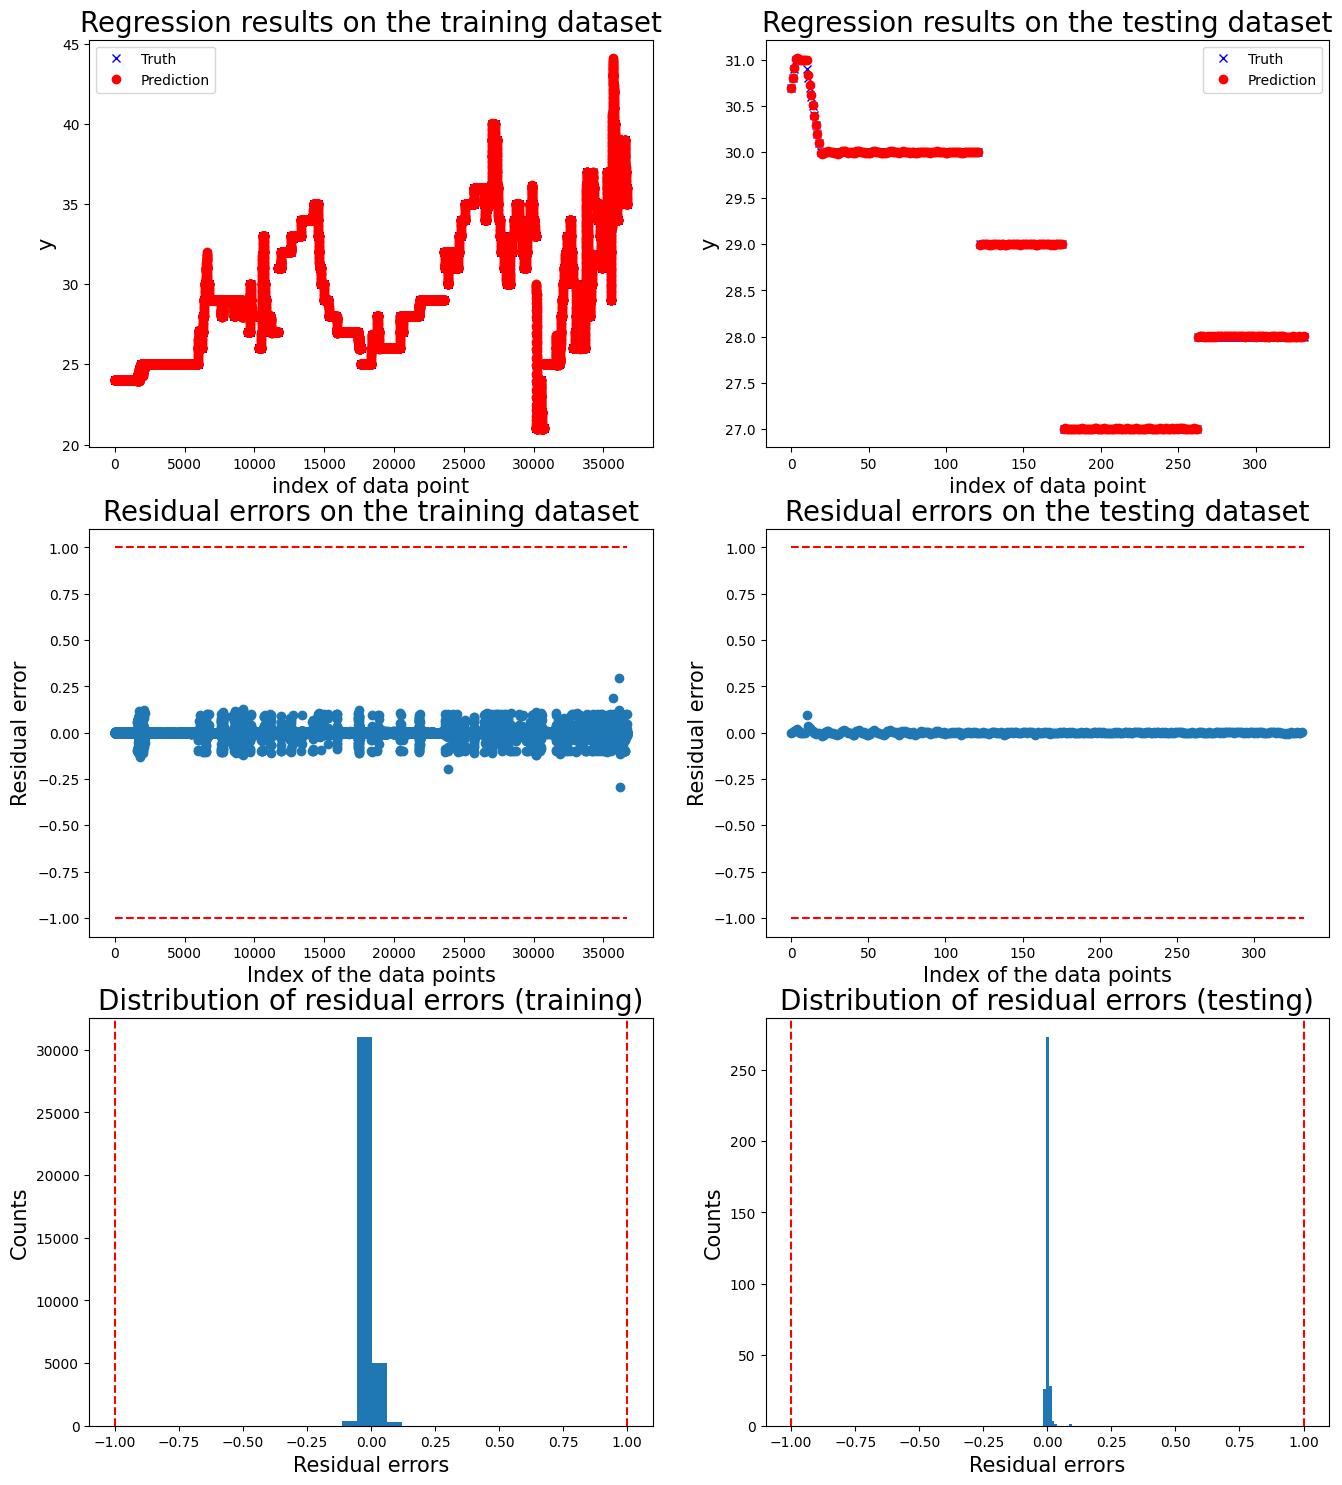


 New run:

training performance, max error is: 0.1943015299880031
training performance, mean root square error is: 0.013437460267504317
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.3023608810055549
testing performance, mean root square error is: 0.021094648259710025
testing performance, residual error > 1: 0.0%


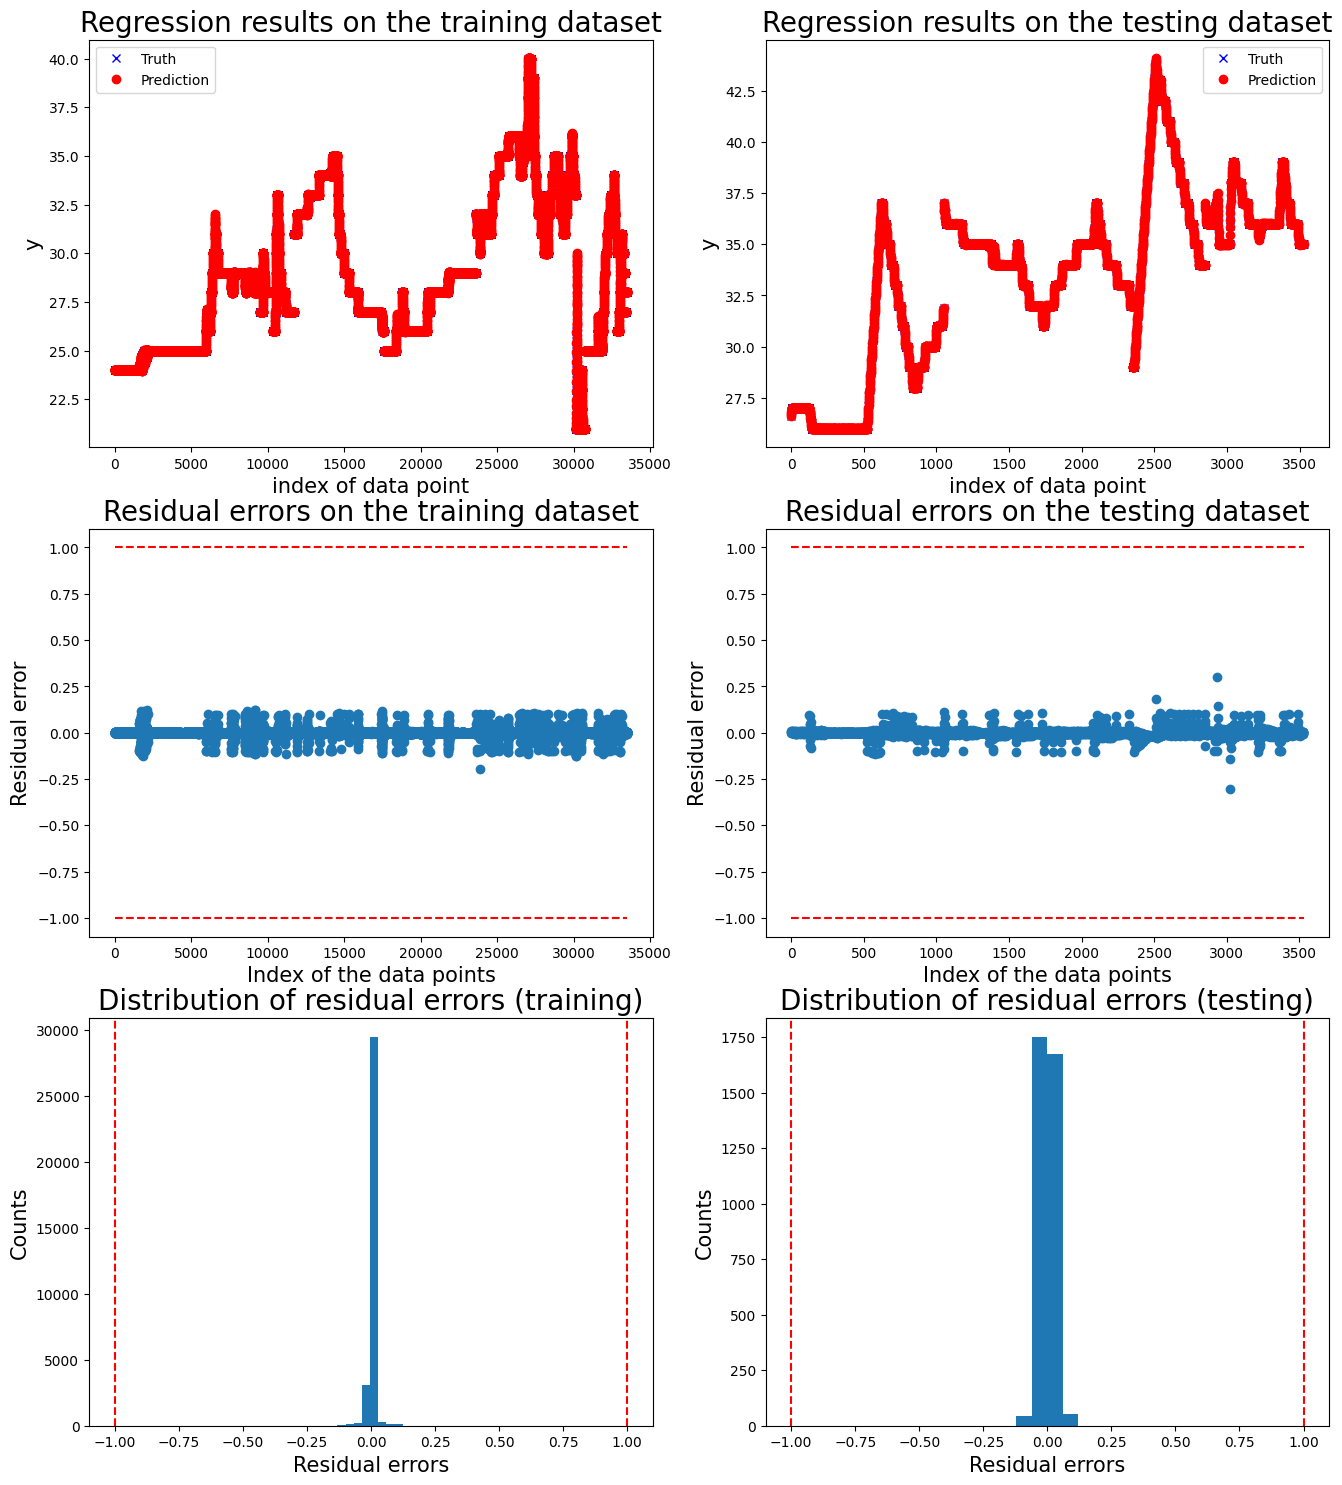

   Max error      RMSE  Exceed boundary rate
0   0.152692  0.018097                   0.0
1   0.192810  0.011730                   0.0
2   0.128664  0.017472                   0.0
3   0.094875  0.007488                   0.0
4   0.302361  0.021095                   0.0


Mean performance metric and standard error:
Max error: 0.1743 +- 0.0800
RMSE: 0.0152 +- 0.0055
Exceed boundary rate: 0.0000 +- 0.0000




,Max error,RMSE,Exceed boundary rate
0,0.152692,0.018097,0.0
1,0.192810,0.011730,0.0
2,0.128664,0.017472,0.0
3,0.094875,0.007488,0.0
4,0.302361,0.021095,0.0


In [10]:
mdl = Pipeline(steps = [
                        ('standardizer', StandardScaler()),
                        ('regressor', LinearRegression())])

run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl, 
        feature_list=feature_list, n_fold=5, single_run_result=True, 
        threshold=1, window_size=100, sample_step=1, mdl_type='reg')

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

In [93]:
# Test the class FaultDetectReg

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from utility_2 import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg, show_reg_result, show_clf_result

def remove_outliers_function(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 70, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 0.5
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()


# Read data.
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers_function, is_plot=False)

# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

feature_list = ['data_motor_1_position','data_motor_1_temperature',
                    'data_motor_3_position', 'data_motor_3_temperature',
                    'data_motor_4_temperature']

feature_list_2 = [f"data_motor_{i}_position" for i in range(1,7)] + [f"data_motor_{i}_voltage" for i in range(1,7)] + [f"data_motor_{i}_temperature" for i in range(1,7)]

features_voltage= [f"data_motor_{i}_voltage" for i in range(1,7)]
features_temperature= [f"data_motor_{i}_temperature" for i in range(1,7)]


# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 50
sample_step = 1
prediction_lead_time = 1
threshold = 0.02
abnormal_limit = 2

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

from sklearn.preprocessing import MinMaxScaler
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regression = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regression.fit(x_tr, y_temp_tr)

# Test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Define the fault detector.
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, 
                              window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# # Test
# _, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list, motor_idx=6, mdl_type='clf')
# x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list, motor_idx=6, mdl_type='reg')

# # Predict the temperature
# detector_reg.threshold = 0.5
# y_label_pred_tr, y_temp_pred_tr = detector_reg.predict(df_x_test=x_tr_org, y_response_test=y_temp_tr_org)
# y_label_pred_tmp, y_temp_pred_tmp = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org)

# # Get the true values.
# _, y_label_test = prepare_sliding_window(df_x=x_test_org, y=y_label_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='clf')
# _, y_temp_test_seq = prepare_sliding_window(df_x=x_test_org, y=y_temp_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')


# show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test_seq, y_pred_tr=y_temp_pred_tr, y_pred=y_temp_pred_tmp, threshold=detector_reg.threshold)
# show_clf_result(y_tr=np.zeros(len(y_label_pred_tr)), y_test=y_label_test, y_pred_tr=y_label_pred_tr, y_pred=y_label_pred_tmp)

# # Run cross validation
n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold, single_run_result=False)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

Model for motor 6:


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


   Accuracy  Precision    Recall  F1 score
0  0.901863   0.477997  0.508885  0.492958
1  0.868132   0.790000  0.963415  0.868132
2  0.727984   0.479839  0.922481  0.631300
3  0.955779   0.602151  0.888889  0.717949
4  0.354545   0.327307  0.991354  0.492132
5  0.941818   0.960905  0.972917  0.966874
6  0.362637   0.311377  0.981132  0.472727


Mean performance metric and standard error:
Accuracy: 0.7304 +- 0.2647
Precision: 0.5642 +- 0.2396
Recall: 0.8899 +- 0.1718
F1 score: 0.6632 +- 0.1970




## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| LinRegressor (window = 50, sample = 1, pred = 1, treshold = 0.1, abnormal = 3) |  0.6574 +- 0.2126 |   0.6574 +- 0.2126 | 0.6574 +- 0.2126 | 0.5327 +- 0.2662 |
| ElasticNet (window = 50, sample = 1, pred = 1, treshold = 0.2, abnormal = 3) | 0.6875 +- 0.3007 |   0.5270 +- 0.2616| 0.8871 +- 0.1850|  0.6265 +- 0.2023|
| RandomForest (window = 50, sample = 1, pred = 1, treshold = 0.15, abnormal = 3) |   0.7475 +- 0.0489  |   0.6089 +- 0.3655  |   0.6379 +- 0.2708| 0.5307 +- 0.1867|
| SVR (window = 20, sample = 1, pred = 1, treshold = 0.3, abnormal = 3) |   0.6145 +- 0.1842  |   0.6089 +- 0.1285  |   0.6784 +- 0.3145| 0.5725 +- 0.1421|
| LinRegressor (all features, window = 100, treshold = 0.005, abnormal = 3) |  0.4689 +- 0.3210 |   0.3895 +- 0.3285 | 0.6574 +- 0.2126 | 0.5073 +- 0.2836|
| LinRegressor (voltage features, window = 100, treshold = 0.01, abnormal = 3) |  0.3869 +- 0.2540 |   0.3821 +- 0.3600 |0.8625 +- 0.1543|  0.4571 +- 0.2834|
| LinRegressor (temperature features, window = 100, treshold = 0.01, abnormal = 3) |  0.5755 +- 0.3051|   0.4542 +- 0.3189 |0.9289 +- 0.0976|  0.5669 +- 0.2832|
| LinRegressor (window = 50, sample = 1, pred = 1, treshold = 0.015, abnormal = 3) | 0.7321 +- 0.2655 |   0.5660 +- 0.2407 | 0.8943 +- 0.1745 |  0.6655 +- 0.1981 |

We tried a lot of models with a whole range of differents parameters. The best results we had is a 67% of f1 score with a linear regressor and a treshold of 0.015. It seems that other models don't work as good as the Linear Regressor. The sample_step and prediction_lead_time should be set to one. On every test we made, increasing those parameters resulted in a worse f1 score.  

We could improve it by working on the preprocessing : the feature selection is not optimized, the function to remove outliers could also be optimized. Maybe with this we would have better results.  
Below, we can see the result from the best model we had :  

100%|██████████| 7/7 [00:23<00:00,  3.40s/it]



 New run:

training performance, max error is: 9.517231818322387
training performance, mean root square error is: 1.314198525205577
training performance, residual error > 0.03591614935467774: 69.85788536328282%

 New run:

testing performance, max error is: 9.392022057063244
testing performance, mean root square error is: 0.8193853617392646
testing performance, residual error > 0.03591614935467774: 32.73971318774018%


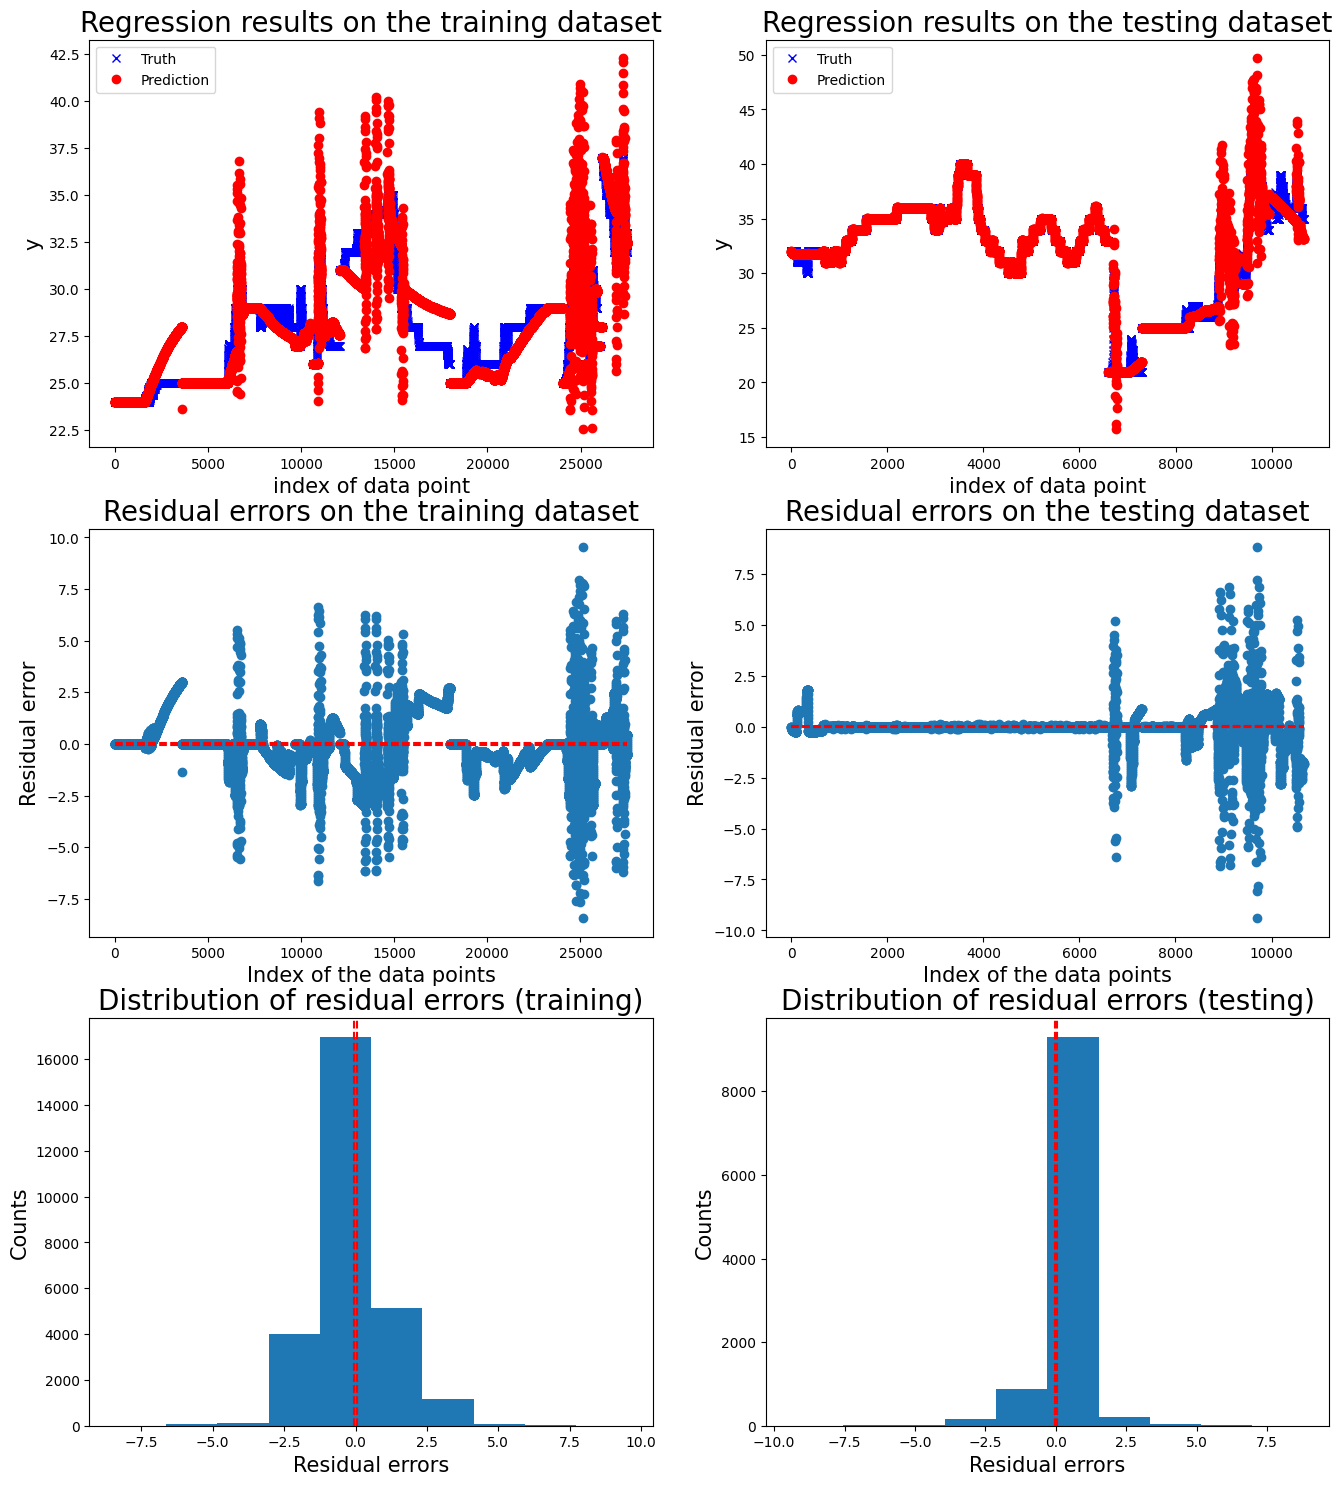


 New run:

training performance, accuracy is: 0.2992767055573729
training performance, precision is: 0.0
training performance, recall: 0.0
training performance, F1: 0.0



 New run:

testing performance, accuracy is: 0.8071046958477833
testing performance, precision is: 0.48097826086956524
testing performance, recall: 0.8245341614906833
testing performance, F1: 0.6075514874141876




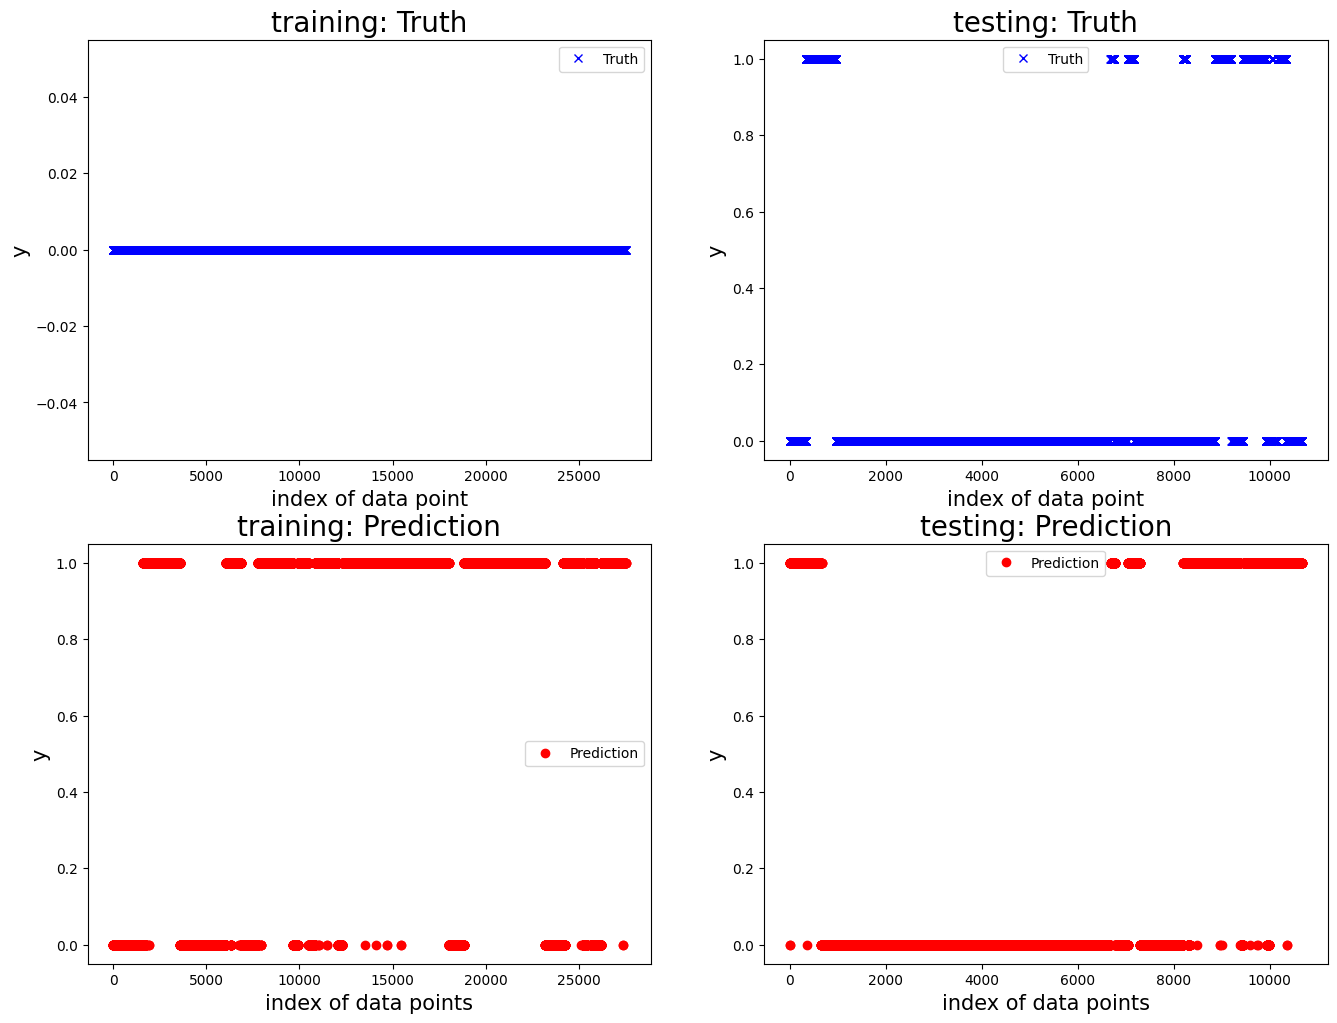

Model for motor 6:


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


   Accuracy  Precision    Recall  F1 score
0  0.901863   0.477997  0.508885  0.492958
1  0.879121   0.800000  0.975610  0.879121
2  0.727984   0.479839  0.922481  0.631300
3  0.955779   0.602151  0.888889  0.717949
4  0.355455   0.327619  0.991354  0.492484
5  0.941818   0.960905  0.972917  0.966874
6  0.362637   0.313609  1.000000  0.477477


Mean performance metric and standard error:
Accuracy: 0.7321 +- 0.2655
Precision: 0.5660 +- 0.2407
Recall: 0.8943 +- 0.1745
F1 score: 0.6655 +- 0.1981




In [69]:
# Test the class FaultDetectReg

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from utility_2 import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg, show_reg_result, show_clf_result

def remove_outliers_function(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 70, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 0.5
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()


# Read data.
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers_function, is_plot=False)

# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

feature_list = ['data_motor_1_position','data_motor_1_temperature',
                    'data_motor_3_position', 'data_motor_3_temperature',
                    'data_motor_4_temperature']

feature_list_2 = [f"data_motor_{i}_position" for i in range(1,7)] + [f"data_motor_{i}_voltage" for i in range(1,7)] + [f"data_motor_{i}_temperature" for i in range(1,7)]

features_voltage= [f"data_motor_{i}_voltage" for i in range(1,7)]
features_temperature= [f"data_motor_{i}_temperature" for i in range(1,7)]


# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 50
sample_step = 1
prediction_lead_time = 1
threshold = 0.015
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

from sklearn.preprocessing import MinMaxScaler
# Define the steps of the pipeline
steps = [
    ('standardizer', MinMaxScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regression = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regression.fit(x_tr, y_temp_tr)

# Test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Define the fault detector.
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, 
                              window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# # Test
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list, motor_idx=6, mdl_type='reg')

# Predict the temperature
detector_reg.threshold = 0.5
y_label_pred_tr, y_temp_pred_tr = detector_reg.predict(df_x_test=x_tr_org, y_response_test=y_temp_tr_org)
y_label_pred_tmp, y_temp_pred_tmp = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org)

# Get the true values.
_, y_label_test = prepare_sliding_window(df_x=x_test_org, y=y_label_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='clf')
_, y_temp_test_seq = prepare_sliding_window(df_x=x_test_org, y=y_temp_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')


show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test_seq, y_pred_tr=y_temp_pred_tr, y_pred=y_temp_pred_tmp, threshold=detector_reg.threshold)
show_clf_result(y_tr=np.zeros(len(y_label_pred_tr)), y_test=y_label_test, y_pred_tr=y_label_pred_tr, y_pred=y_label_pred_tmp)

# # Run cross validation
n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold, single_run_result=False)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')